In [1]:
import os
import sys
import distutils.core
from IPython.display import clear_output

# Step 1: Set environment variable to avoid OpenMP runtime error
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Step 2: Install pyyaml version 5.1
!python -m pip install pyyaml==5.1

# Step 3: Clone the Detectron2 repository
!git clone https://github.com/facebookresearch/detectron2

# Step 4: Load and read the setup.py file from Detectron2 for dependencies
dist = distutils.core.run_setup("./detectron2/setup.py")

# Step 5: Install Detectron2 dependencies
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}

# Step 6: Add Detectron2 to Python path
sys.path.insert(0, os.path.abspath('./detectron2'))
clear_output()

# Step 7: Install additional required packages
!pip install fvcore
!pip install omegaconf
!pip install pycocotools
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Step 8: Install Detectron2 (compatible with PyTorch 2.x and CUDA 11.8)
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu118/torch2.0/index.html

# Step 9: Clear the output to make notebook cleaner
clear_output()

# Step 10: Verify Detectron2 installation
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

print("Detectron2 installed successfully!")

Detectron2 installed successfully!


In [39]:
import os
import cv2
import torch
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

# Step 1: Load your trained model and predictor
def load_model_and_predictor(cfg_path, weights_path):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(cfg_path))

    # Use the trained weights from your custom model
    cfg.MODEL.WEIGHTS = weights_path

    # Set the number of classes to match your dataset
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # Ensure this matches your dataset

    # Set a threshold for predictions
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6

    # Set the device to GPU if available, else CPU
    cfg.MODEL.DEVICE = "cpu"

    # Initialize the predictor with the configuration
    return DefaultPredictor(cfg)

# Function to visualize predictions on the image
def visualize_predictions(img, outputs):
    v = Visualizer(img[:, :, ::-1], scale=0.8)  # Convert BGR to RGB for visualization
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image())
    plt.axis('off')  # Disable axis
    plt.show()

# Step 2: Function to predict on all images in a folder
def predict_on_folder(input_folder, output_folder, predictor):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Loop through all images in the input folder
    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)
        
        # Read the image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Skipping {img_name}, unable to load image.")
            continue

        # Run inference on the image (pass the original image, no pre-processing)
        try:
            outputs = predictor(img)
            print(img_name)
        except Exception as e:
            print(f"Error processing {img_name}: {str(e)}")
            continue

        # Map class 1 -> 0 and class 2 -> 1
        outputs['instances'].pred_classes = torch.where(
            outputs['instances'].pred_classes == 1, 
            torch.tensor(0), 
            outputs['instances'].pred_classes
        )
        outputs['instances'].pred_classes = torch.where(
            outputs['instances'].pred_classes == 2, 
            torch.tensor(1), 
            outputs['instances'].pred_classes
        )

        # Visualize the predictions
        visualize_predictions(img, outputs)  # <- Visualization step added here

        # Extract instances from predictions
        instances = outputs["instances"].to("cpu")
        boxes = instances.pred_boxes if instances.has("pred_boxes") else None
        scores = instances.scores if instances.has("scores") else None
        classes = instances.pred_classes if instances.has("pred_classes") else None

        # Define the output path for saving
        output_path = os.path.join(output_folder, f"{img_name}_prediction.txt")

        # Open the file for saving predictions
        with open(output_path, "w") as f:
            # If there are no detections, print a message and continue
            if boxes is None or len(boxes) == 0:
                f.write(f"No detections for {img_name}\n")
                print(f"No detections for {img_name}")
                print("-"*100)
                continue

            # Save predictions to the text file
            for i, box in enumerate(boxes):
                f.write(f"Class: {classes[i].item()}, Score: {scores[i].item():.6f}, Box: {box}\n")

        # Print Class, Score, and Box as header
        for i, box in enumerate(boxes):
            header = f"Class: {classes[i].item()}, Score: {scores[i].item():.6f}, Box: {box}"
            print(header)
        print("-"*100)


In [40]:
# Example usage:

# Step 3: Load your model and configuration
cfg_path = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
weights_path = "model_final.pth"  # Path to your trained weights

# Load the predictor
predictor = load_model_and_predictor(cfg_path, weights_path)

# Step 4: Define input folder
input_folder = "./input_images/"  # Folder containing input images
output_folder = "./output_predictions/"

[10/15 17:04:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from model_final.pth ...
[Checkpointer] Loading from model_final.pth ...


c:\Users\jirap\anaconda3\Lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu

01Brain.png


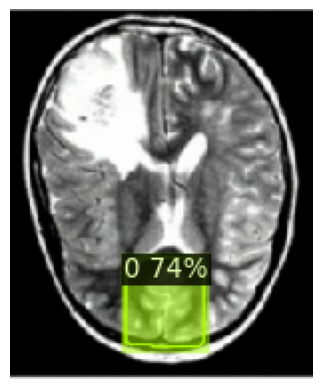

Class: 0, Score: 0.743079, Box: tensor([ 71.5413, 155.1079, 122.7651, 213.7595])
----------------------------------------------------------------------------------------------------
02Brain.png


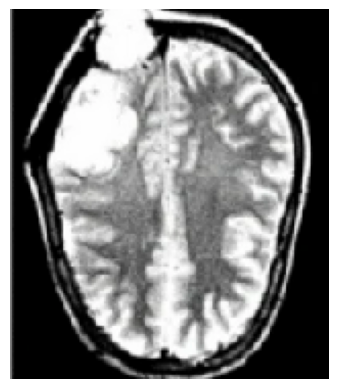

No detections for 02Brain.png
----------------------------------------------------------------------------------------------------
1727_jpg.rf.bb87250fbe9b279286bf5e70c7218ae6.jpg


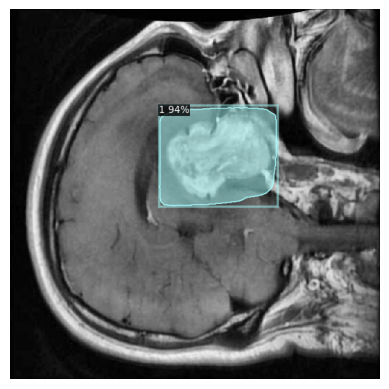

Class: 1, Score: 0.941485, Box: tensor([257.4743, 166.1794, 462.8700, 341.7810])
----------------------------------------------------------------------------------------------------
2181_jpg.rf.79e89943779d1970ca6c67ecd64e597b.jpg


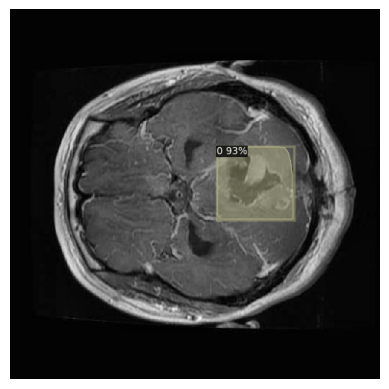

Class: 0, Score: 0.925649, Box: tensor([357.2969, 237.5457, 490.7625, 365.3170])
----------------------------------------------------------------------------------------------------
2358_jpg.rf.261a8a680ae556103a09f2d097e8f600.jpg


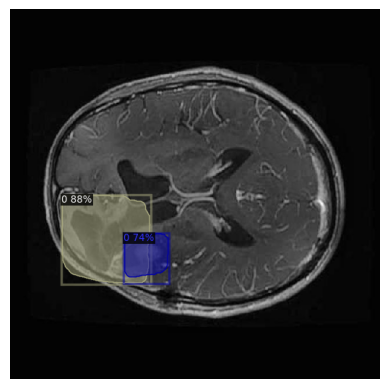

Class: 0, Score: 0.880998, Box: tensor([ 89.1344, 321.0884, 244.3516, 476.3931])
Class: 0, Score: 0.736564, Box: tensor([196.7640, 387.2660, 274.9594, 475.3912])
----------------------------------------------------------------------------------------------------
NewMackBrain.webp


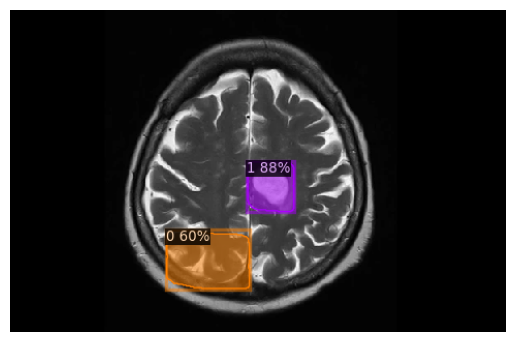

Class: 1, Score: 0.882250, Box: tensor([286.0916, 184.0164, 344.1703, 245.4384])
Class: 0, Score: 0.603440, Box: tensor([188.2131, 265.7545, 290.4161, 338.2960])
----------------------------------------------------------------------------------------------------
NewPeeBrain.jpg


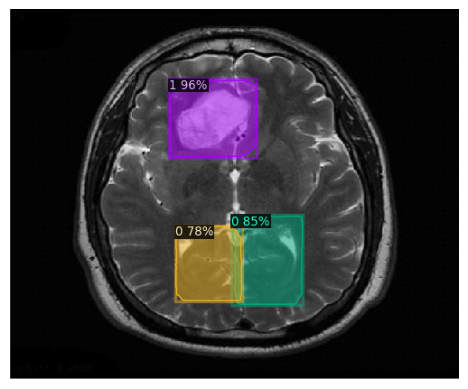

Class: 1, Score: 0.957253, Box: tensor([220.3219,  97.3232, 341.4823, 207.0238])
Class: 0, Score: 0.847090, Box: tensor([306.5251, 285.8716, 405.1771, 411.0782])
Class: 0, Score: 0.776215, Box: tensor([228.7032, 300.0633, 321.3495, 406.1254])
----------------------------------------------------------------------------------------------------


In [41]:
# Step 5: Run predictions on all images in the folder
predict_on_folder(input_folder, output_folder, predictor)